# Gap Analysis Step 1c: Alternative Methods for Calculating the AEP

In [1]:
%load_ext autoreload
%autoreload 2

This notebook provides an overview and walk-through of the augmented capabilities of the `MonteCarloAEP` analysis class, focusing on the application of various approaches within the AEP calculation, notably different time resolutions, regression inputs, and regression models. In this example, we'll also be using the augmented approach to accessing the analysis class creation through the `PlantData` object.

In [2]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import project_ENGIE

/var/folders/q5/tfpytqxn0r396dfg7rk5sj8rwq9tvv/T/ipykernel_78850/2217854450.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Load plant object
project = project_ENGIE.prepare()

/Users/rhammond/GitHub_Public/OpenOA/examples/project_ENGIE.py:106: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  scada_df.loc[ix_turbine, "Ot_avg"].loc[ix_flag.values.flatten()] = np.nan
/Users/rhammond/GitHub_Public/OpenOA/examples/project

## Comparison 1: AEP calculation using different regression models and different time resolution

The updated AEP class includes four different regression algorithms to calculate the long-term operational analysis (OA), accessible by the following `reg_model` inputs:

- Linear regression, `reg_model="lin"` (default)
- Generalized additive regression model, `reg_model="gam"`
- Gradient boosting regressor, `reg_model="gbm"`
- Extremely randomized trees model, `reg_model="etr"`

Linear regression can be selected without any parameter restrictions, but should only be used at monthly resolution because wind plant power curves are not linear at fine time resolutions. On the other hand, as advanced machine learning models are more suited for problems with a large number of data points, we have restricted the use of the "gam", "gbm" and "etr" regressors to OA performed at daily and hourly resolution only.

Here, we'll calculate AEP using all four regression models, using only wind speed as input (Comparison 2 will show an example of a multivariate regression). The linear regression model is run at monthly resolution; the GBM and ETR models at daily resolution; the GAM model at hourly resolution.

In [4]:
aep_lin = project.MonteCarloAEP(
    reanalysis_products=["merra2", "era5"],
    time_resolution="M",
    reg_temperature=False,
    reg_wind_direction=False,
    reg_model="lin",
)

aep_gam = project.MonteCarloAEP(
    reanalysis_products=["merra2", "era5"],
    time_resolution="h",
    reg_temperature=False,
    reg_wind_direction=False,
    reg_model="gam",
)

aep_gbm = project.MonteCarloAEP(
    reanalysis_products=["merra2", "era5"],
    time_resolution="D",
    reg_temperature=False,
    reg_wind_direction=False,
    reg_model="gbm",
)

aep_etr = project.MonteCarloAEP(
    reanalysis_products=["merra2", "era5"],
    time_resolution="D",
    reg_temperature=False,
    reg_wind_direction=False,
    reg_model="etr",
)

As an example, the monthly data frame below includes wind speed averages for both the reanalysis products selected for the analysis.

In [5]:
# View the monthly data frame
aep_lin.aggregate.head()

,energy_gwh,energy_nan_perc,num_days_expected,num_days_actual,availability_gwh,curtailment_gwh,gross_energy_gwh,availability_pct,curtailment_pct,avail_nan_perc,curt_nan_perc,nan_flag,availability_typical,curtailment_typical,combined_loss_valid,merra2,era5
time,,,,,,,,,,,,,,,,,
2014-01-01,1.279667,0.0,31,31,0.008721,0.000000,1.288387,0.006769,0.000000,0.0,0.0,False,True,True,True,7.227947,7.314878
2014-02-01,1.793873,0.0,28,28,0.005280,0.000000,1.799153,0.002934,0.000000,0.0,0.0,False,True,True,True,8.598686,8.347006
2014-03-01,0.805549,0.0,31,31,0.000151,0.000000,0.805700,0.000188,0.000000,0.0,0.0,False,True,True,True,5.207071,5.169673
2014-04-01,0.636472,0.0,30,30,0.002773,0.000000,0.639245,0.004338,0.000000,0.0,0.0,False,True,True,True,4.872304,4.756275
2014-05-01,1.154255,0.0,31,31,0.015176,0.000225,1.169656,0.012974,0.000192,0.0,0.0,False,True,True,True,6.351635,6.162751


Now, let's run the Monte-Carlo AEP analysis for the four setups specified above, where the following cell runs each model for 1000 simulations.

The following lines of code launch the Monte Carlo-based OA for AEP. We identify each source of uncertainty in the OA estimate and use that uncertainty to create distributions of the input and intermediate variables from which we can sample for each iteration of the OA code. 

We repeat the OA process "num_sim" times using different sampling combinations of the input and intermediate variables to produce a distribution of AEP values. Running the OA with the machine learning models at daily resolution is significantly slower than the case of a simple linear regression. Therefore, we have reduced the num_sim parameter to speed up the computation here. Once again, for a detailed description of the steps in the OA process, please refer to the standard AEP example notebook.


In [6]:
aep_lin.run(num_sim=1000)  # Monthly data, linear regression

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 443.84it/s]


In [7]:
aep_gam.run(num_sim=1000)  # Hourly data, generalized additive model

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:46<00:00,  4.42it/s]


In [8]:
aep_gbm.run(num_sim=1000)  # Daily data, gradient boosting machine

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:06<00:00,  4.05it/s]


In [9]:
aep_etr.run(num_sim=1000)  # Daily data, extra randomized trees

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:28<00:00,  3.04it/s]


The key results for the AEP analysis are shown below: distributions of AEP values from which uncertainty can be deduced. We can now compare the AEP distributions obtained for the four configurations of the OA.

In [10]:
# Create consistent axis limits between the plots to show the differences between the distributions
plotting_kwargs = {
    "xlim_aep": (8, 18),
    "xlim_availability": (0.8, 1.6),
    "xlim_curtail": (0.03, 0.08),
    "ylim_aep": (0, 0.5),
    "ylim_availability": (0, 8),
    "ylim_curtail": (0, 200),
}

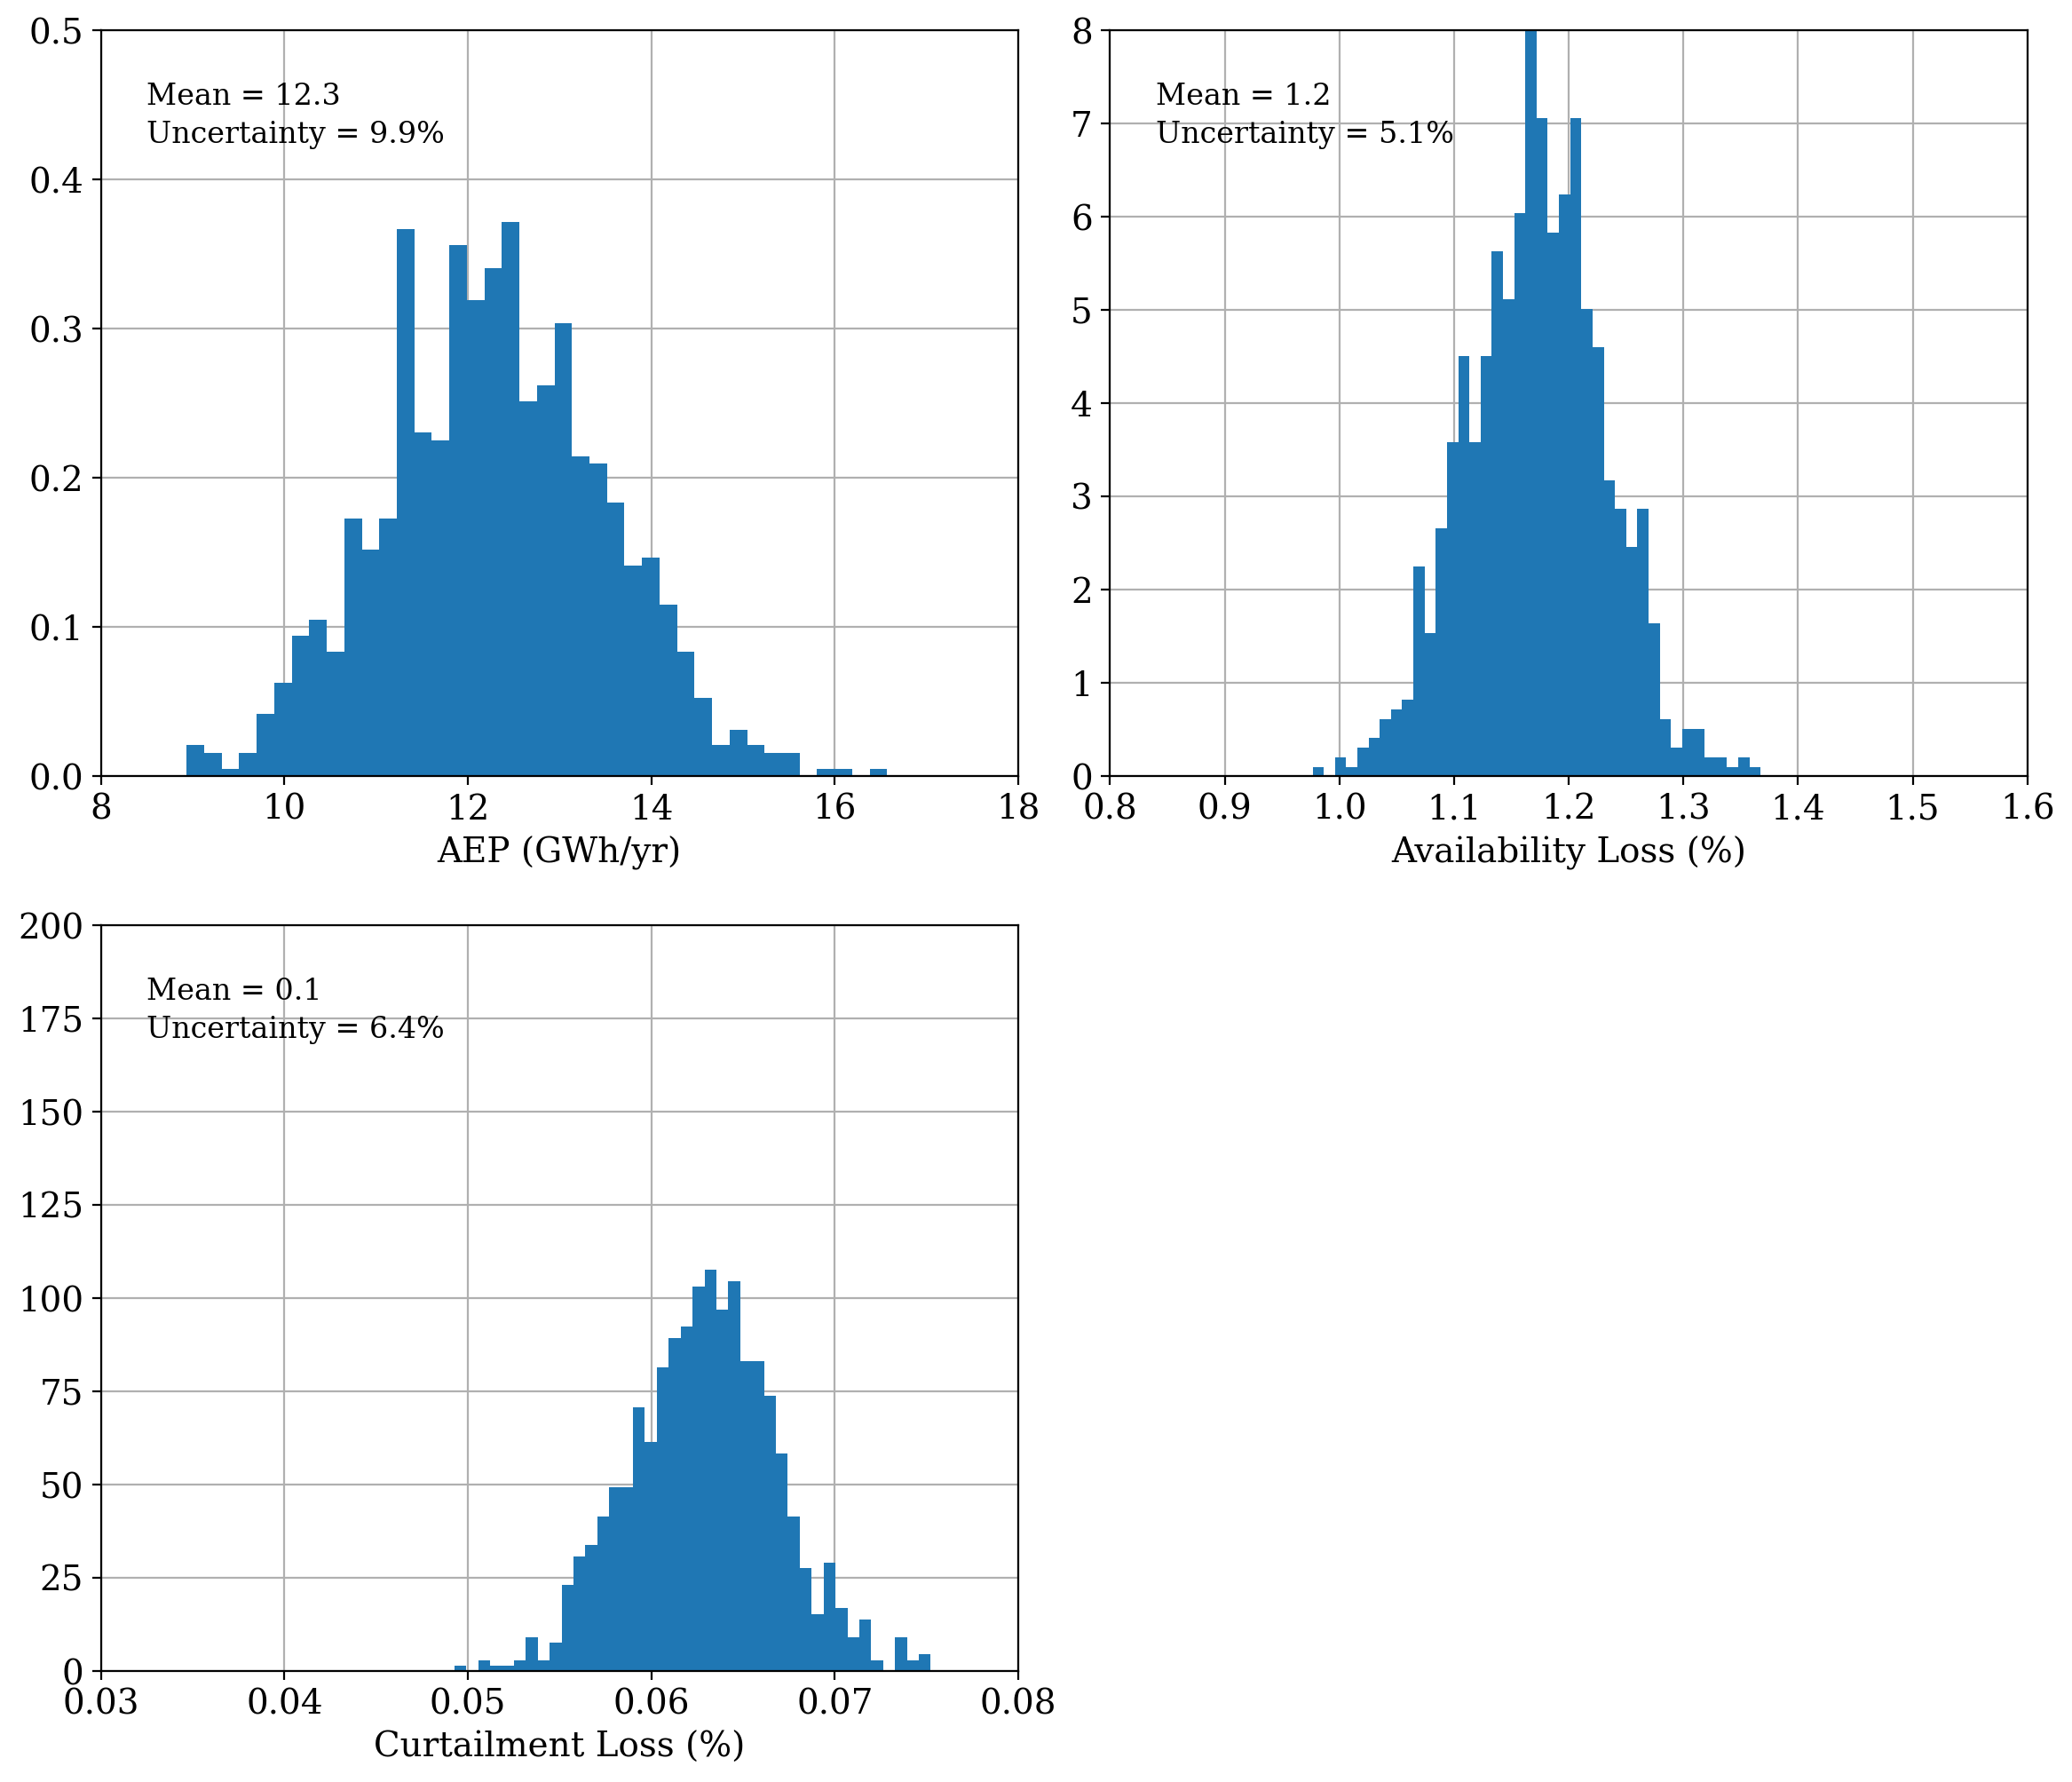

In [11]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - wind speed only
aep_lin.plot_result_aep_distributions(**plotting_kwargs)

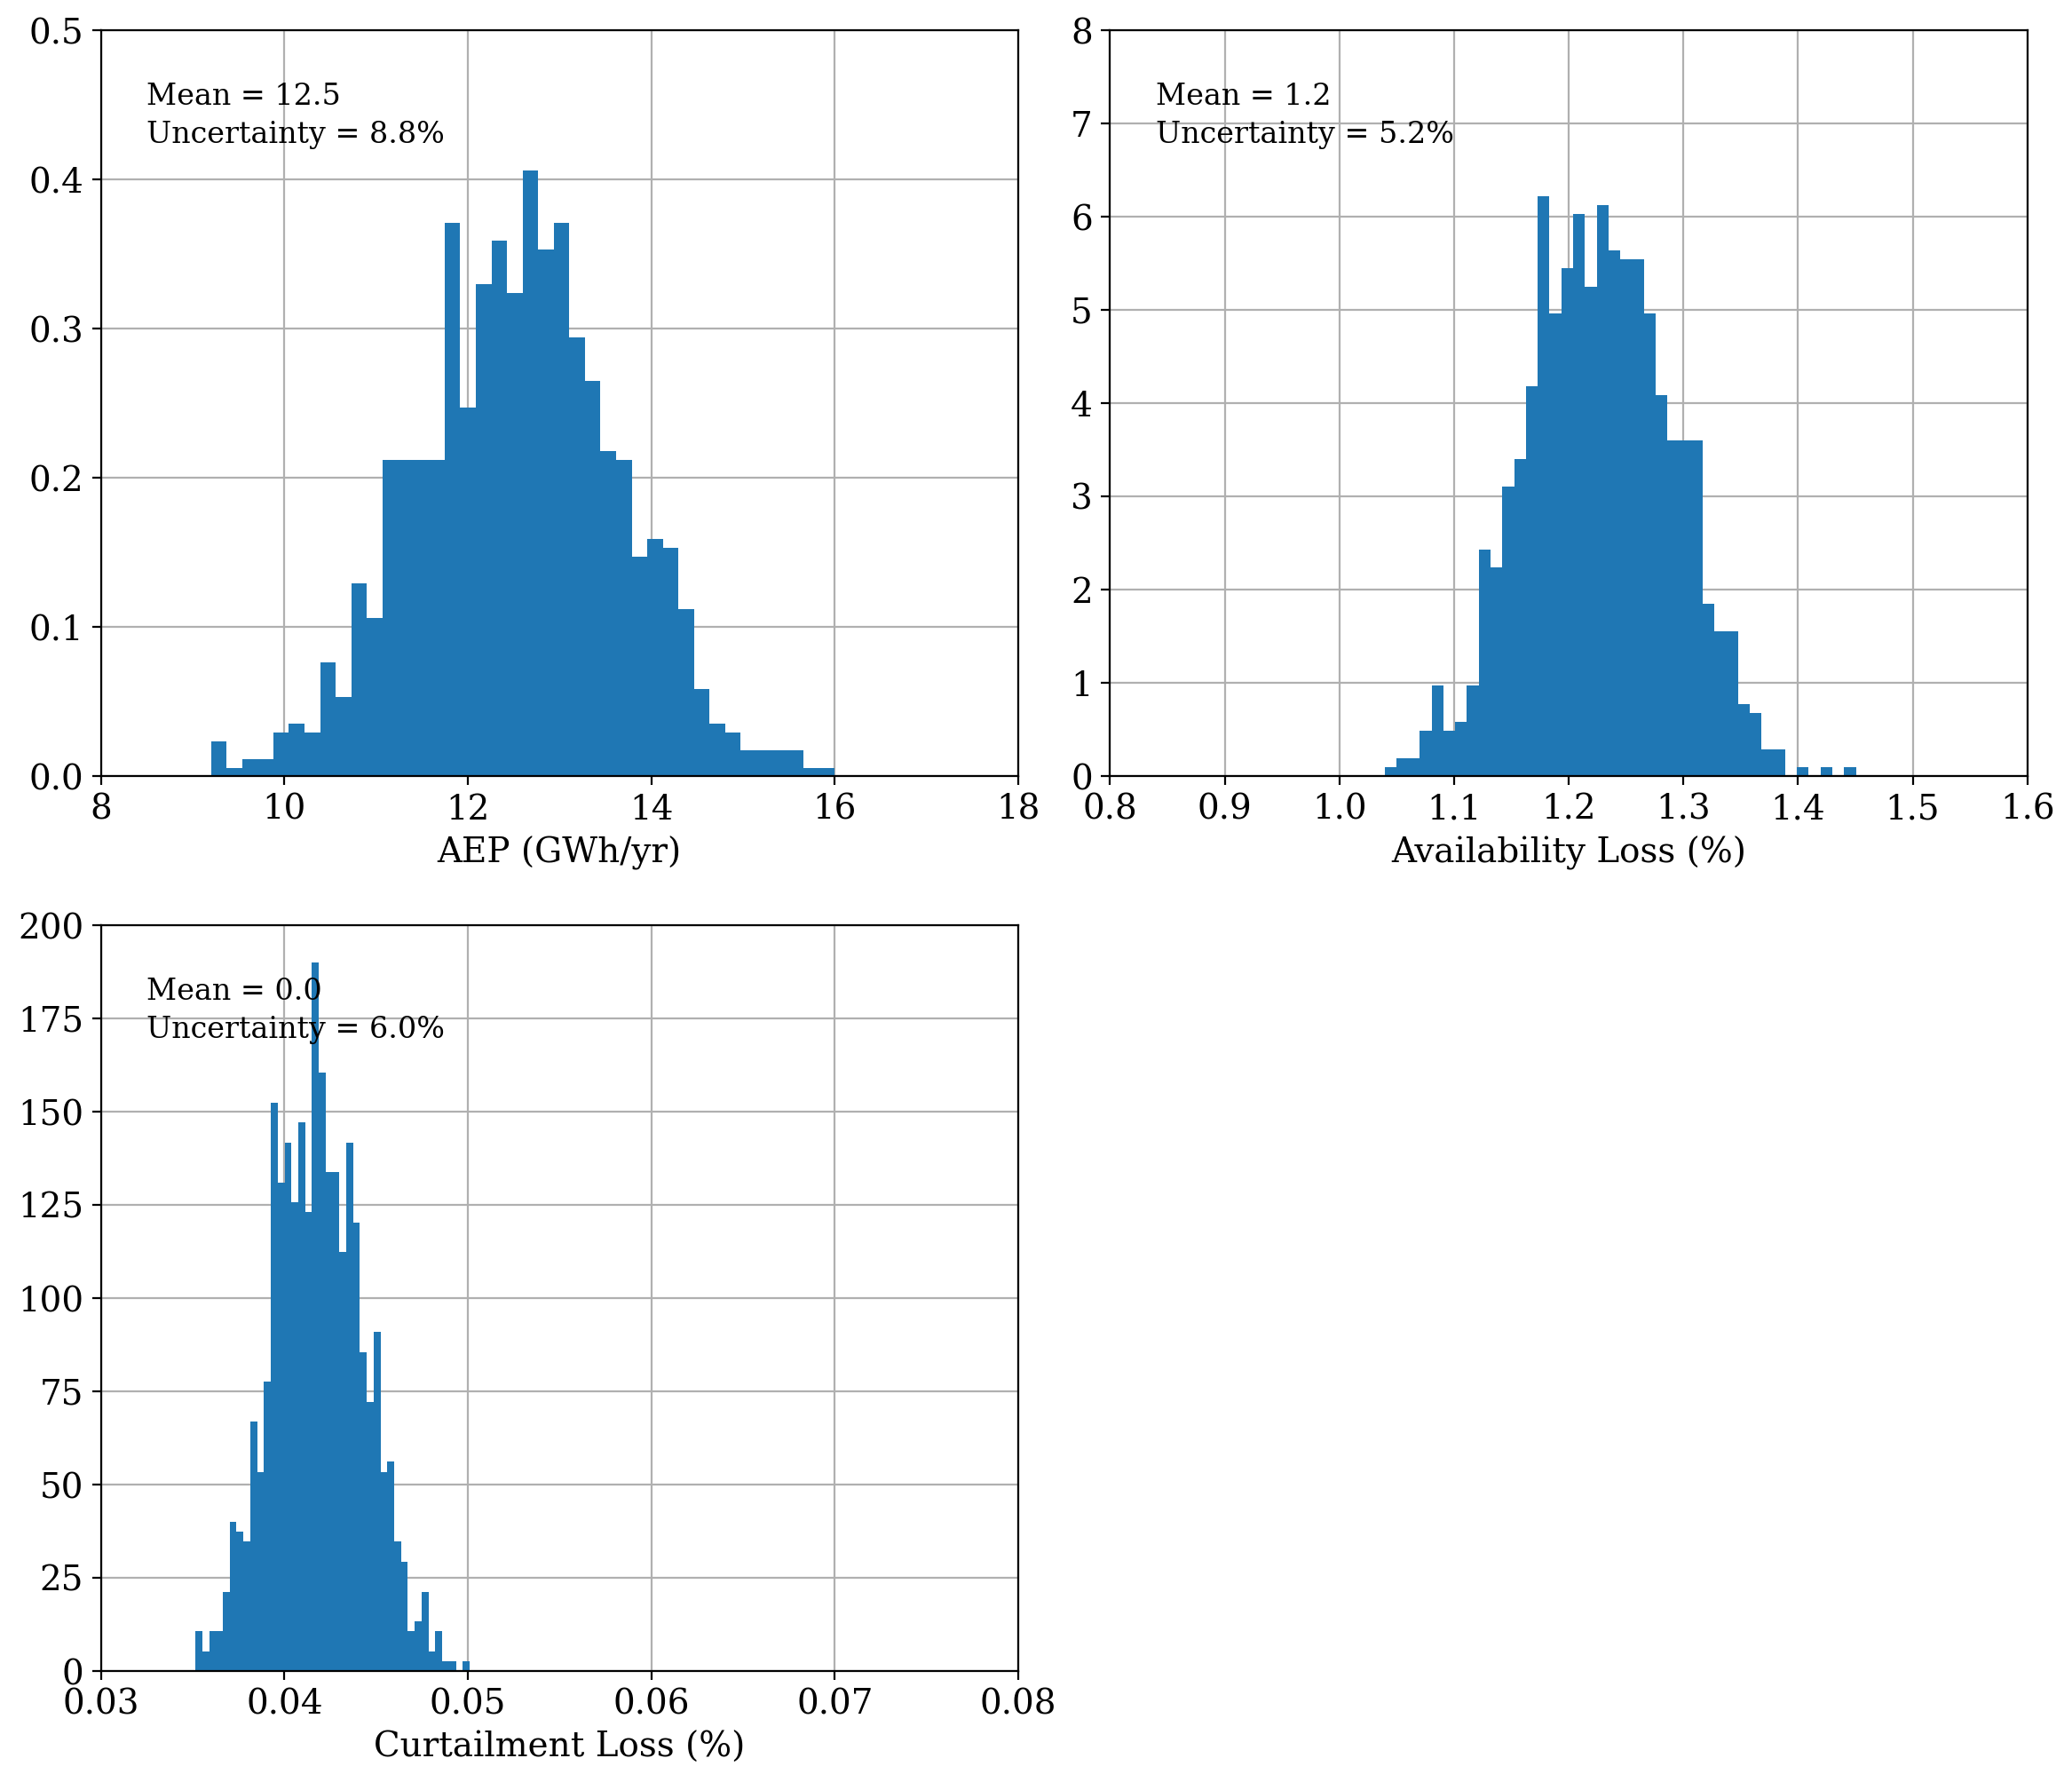

In [12]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - gam model
aep_gam.plot_result_aep_distributions(**plotting_kwargs)

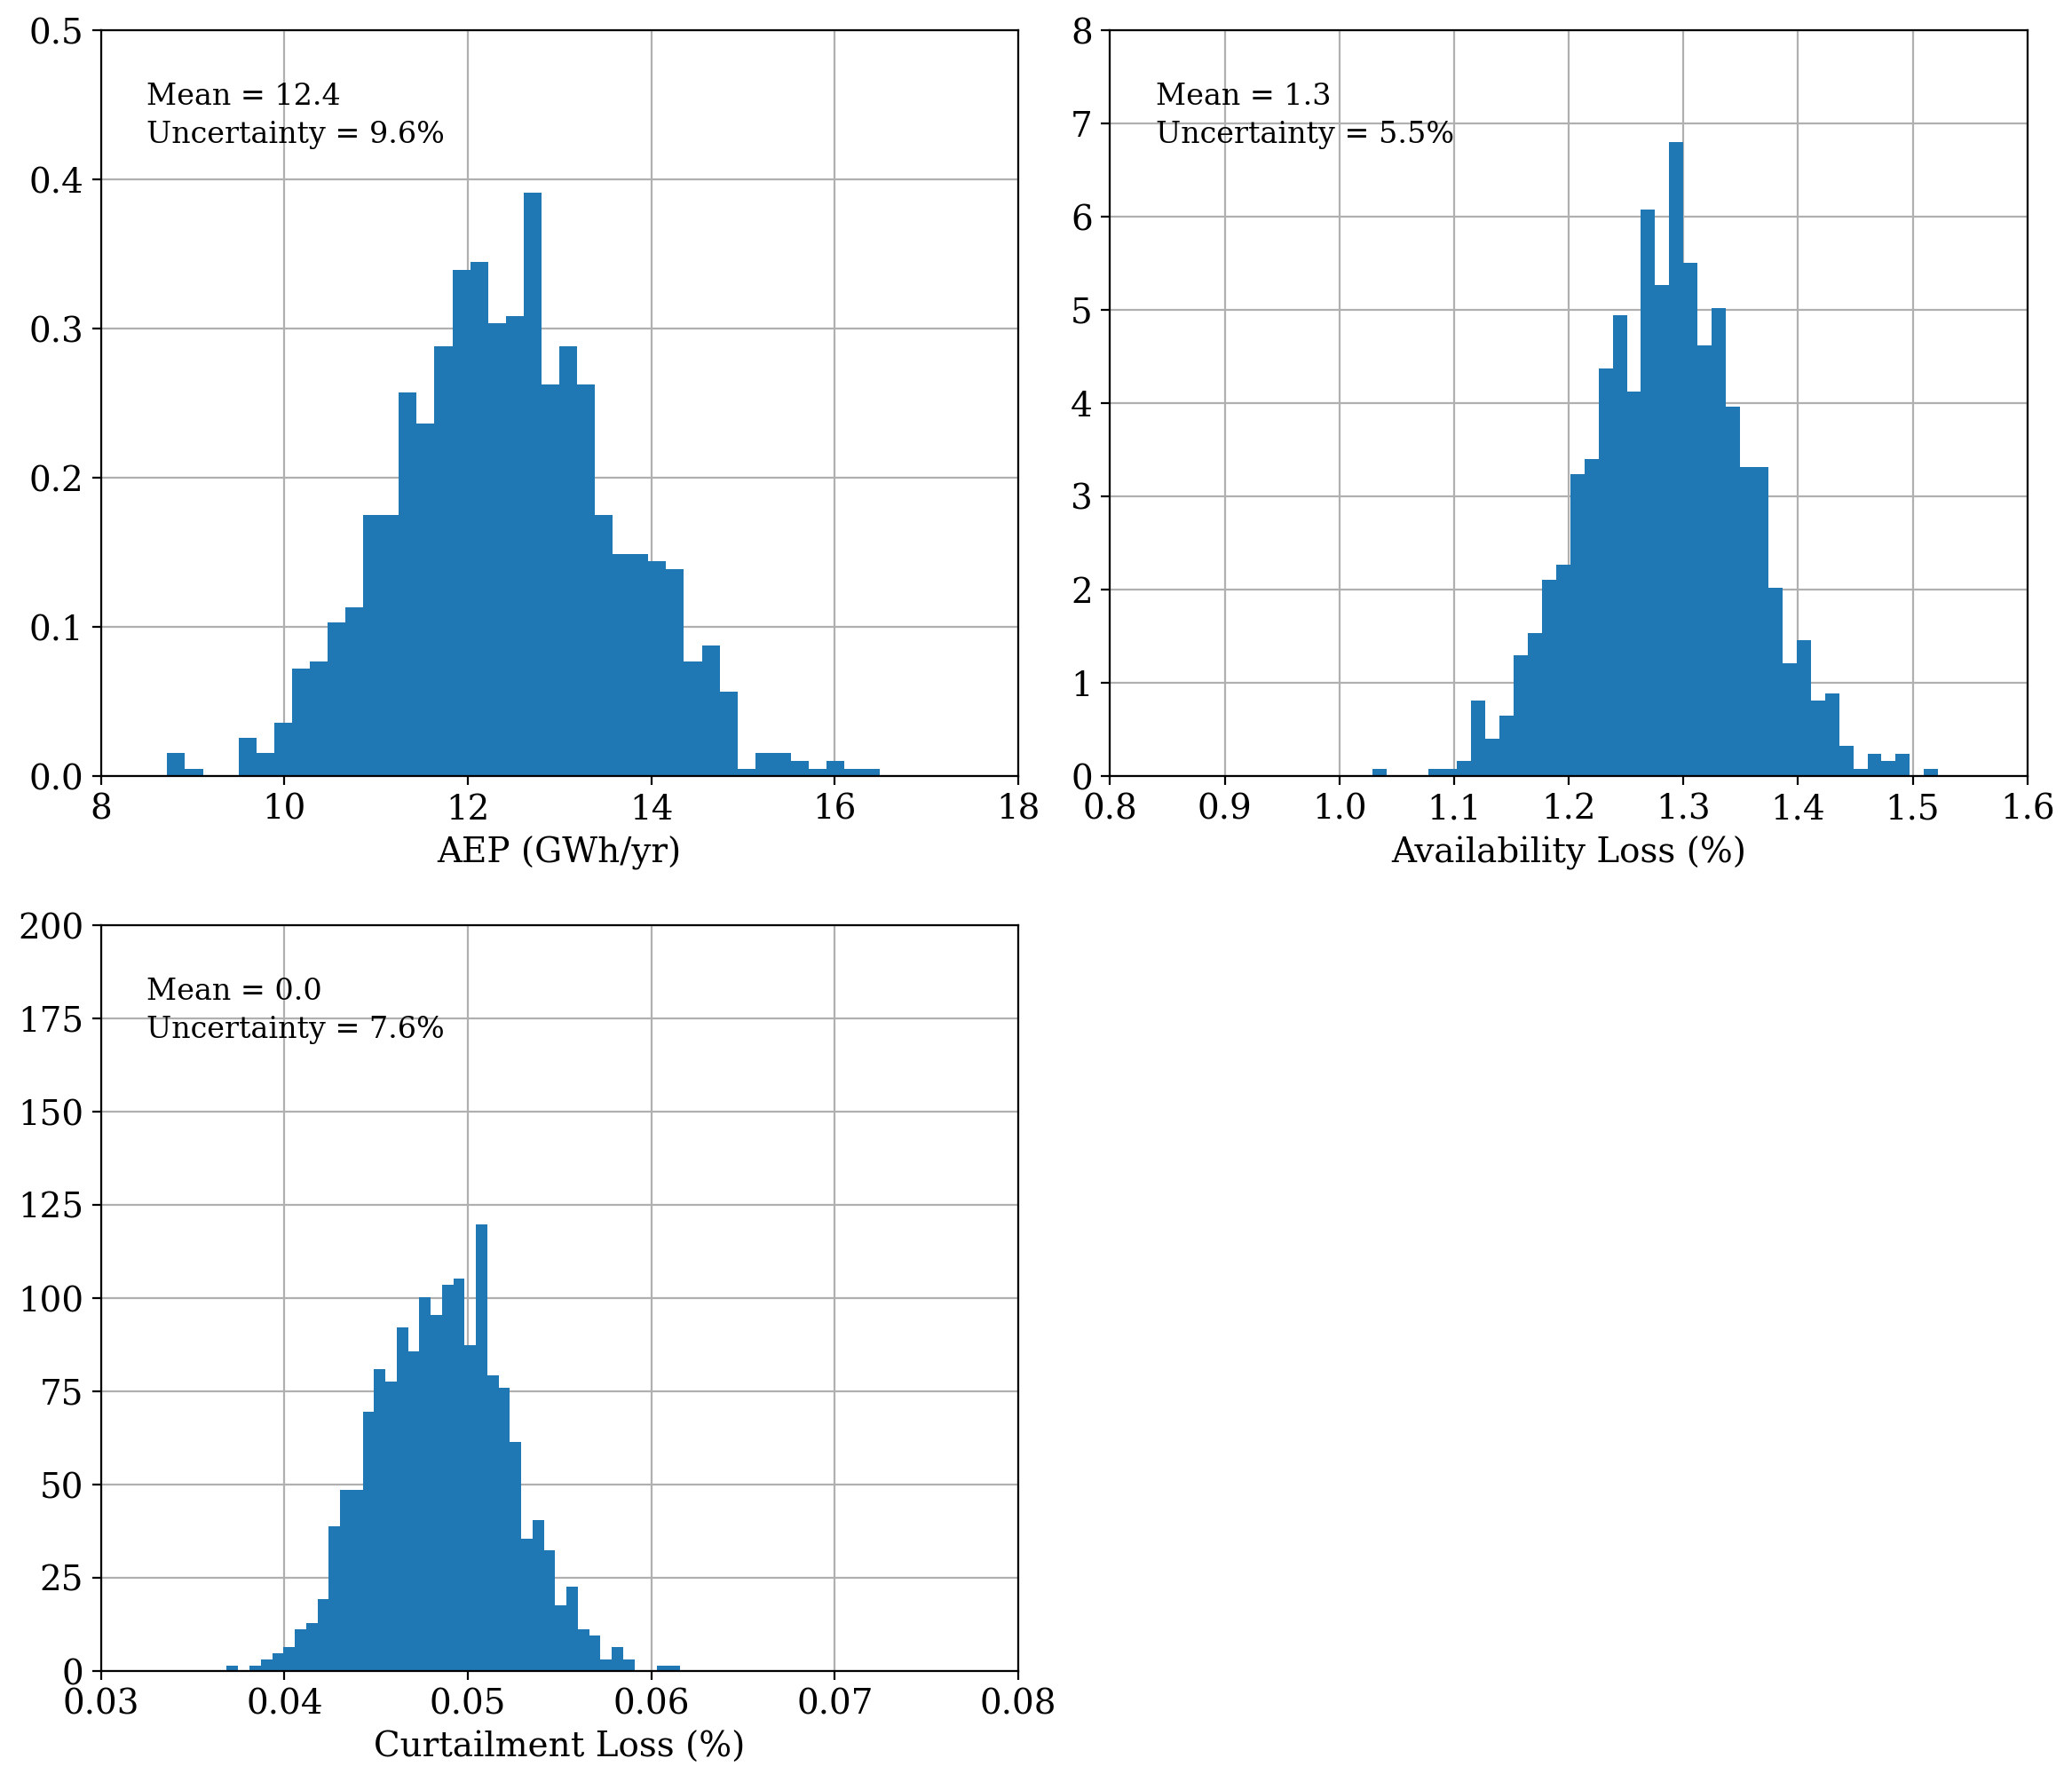

In [13]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - gradient boosting model
aep_gbm.plot_result_aep_distributions(**plotting_kwargs)

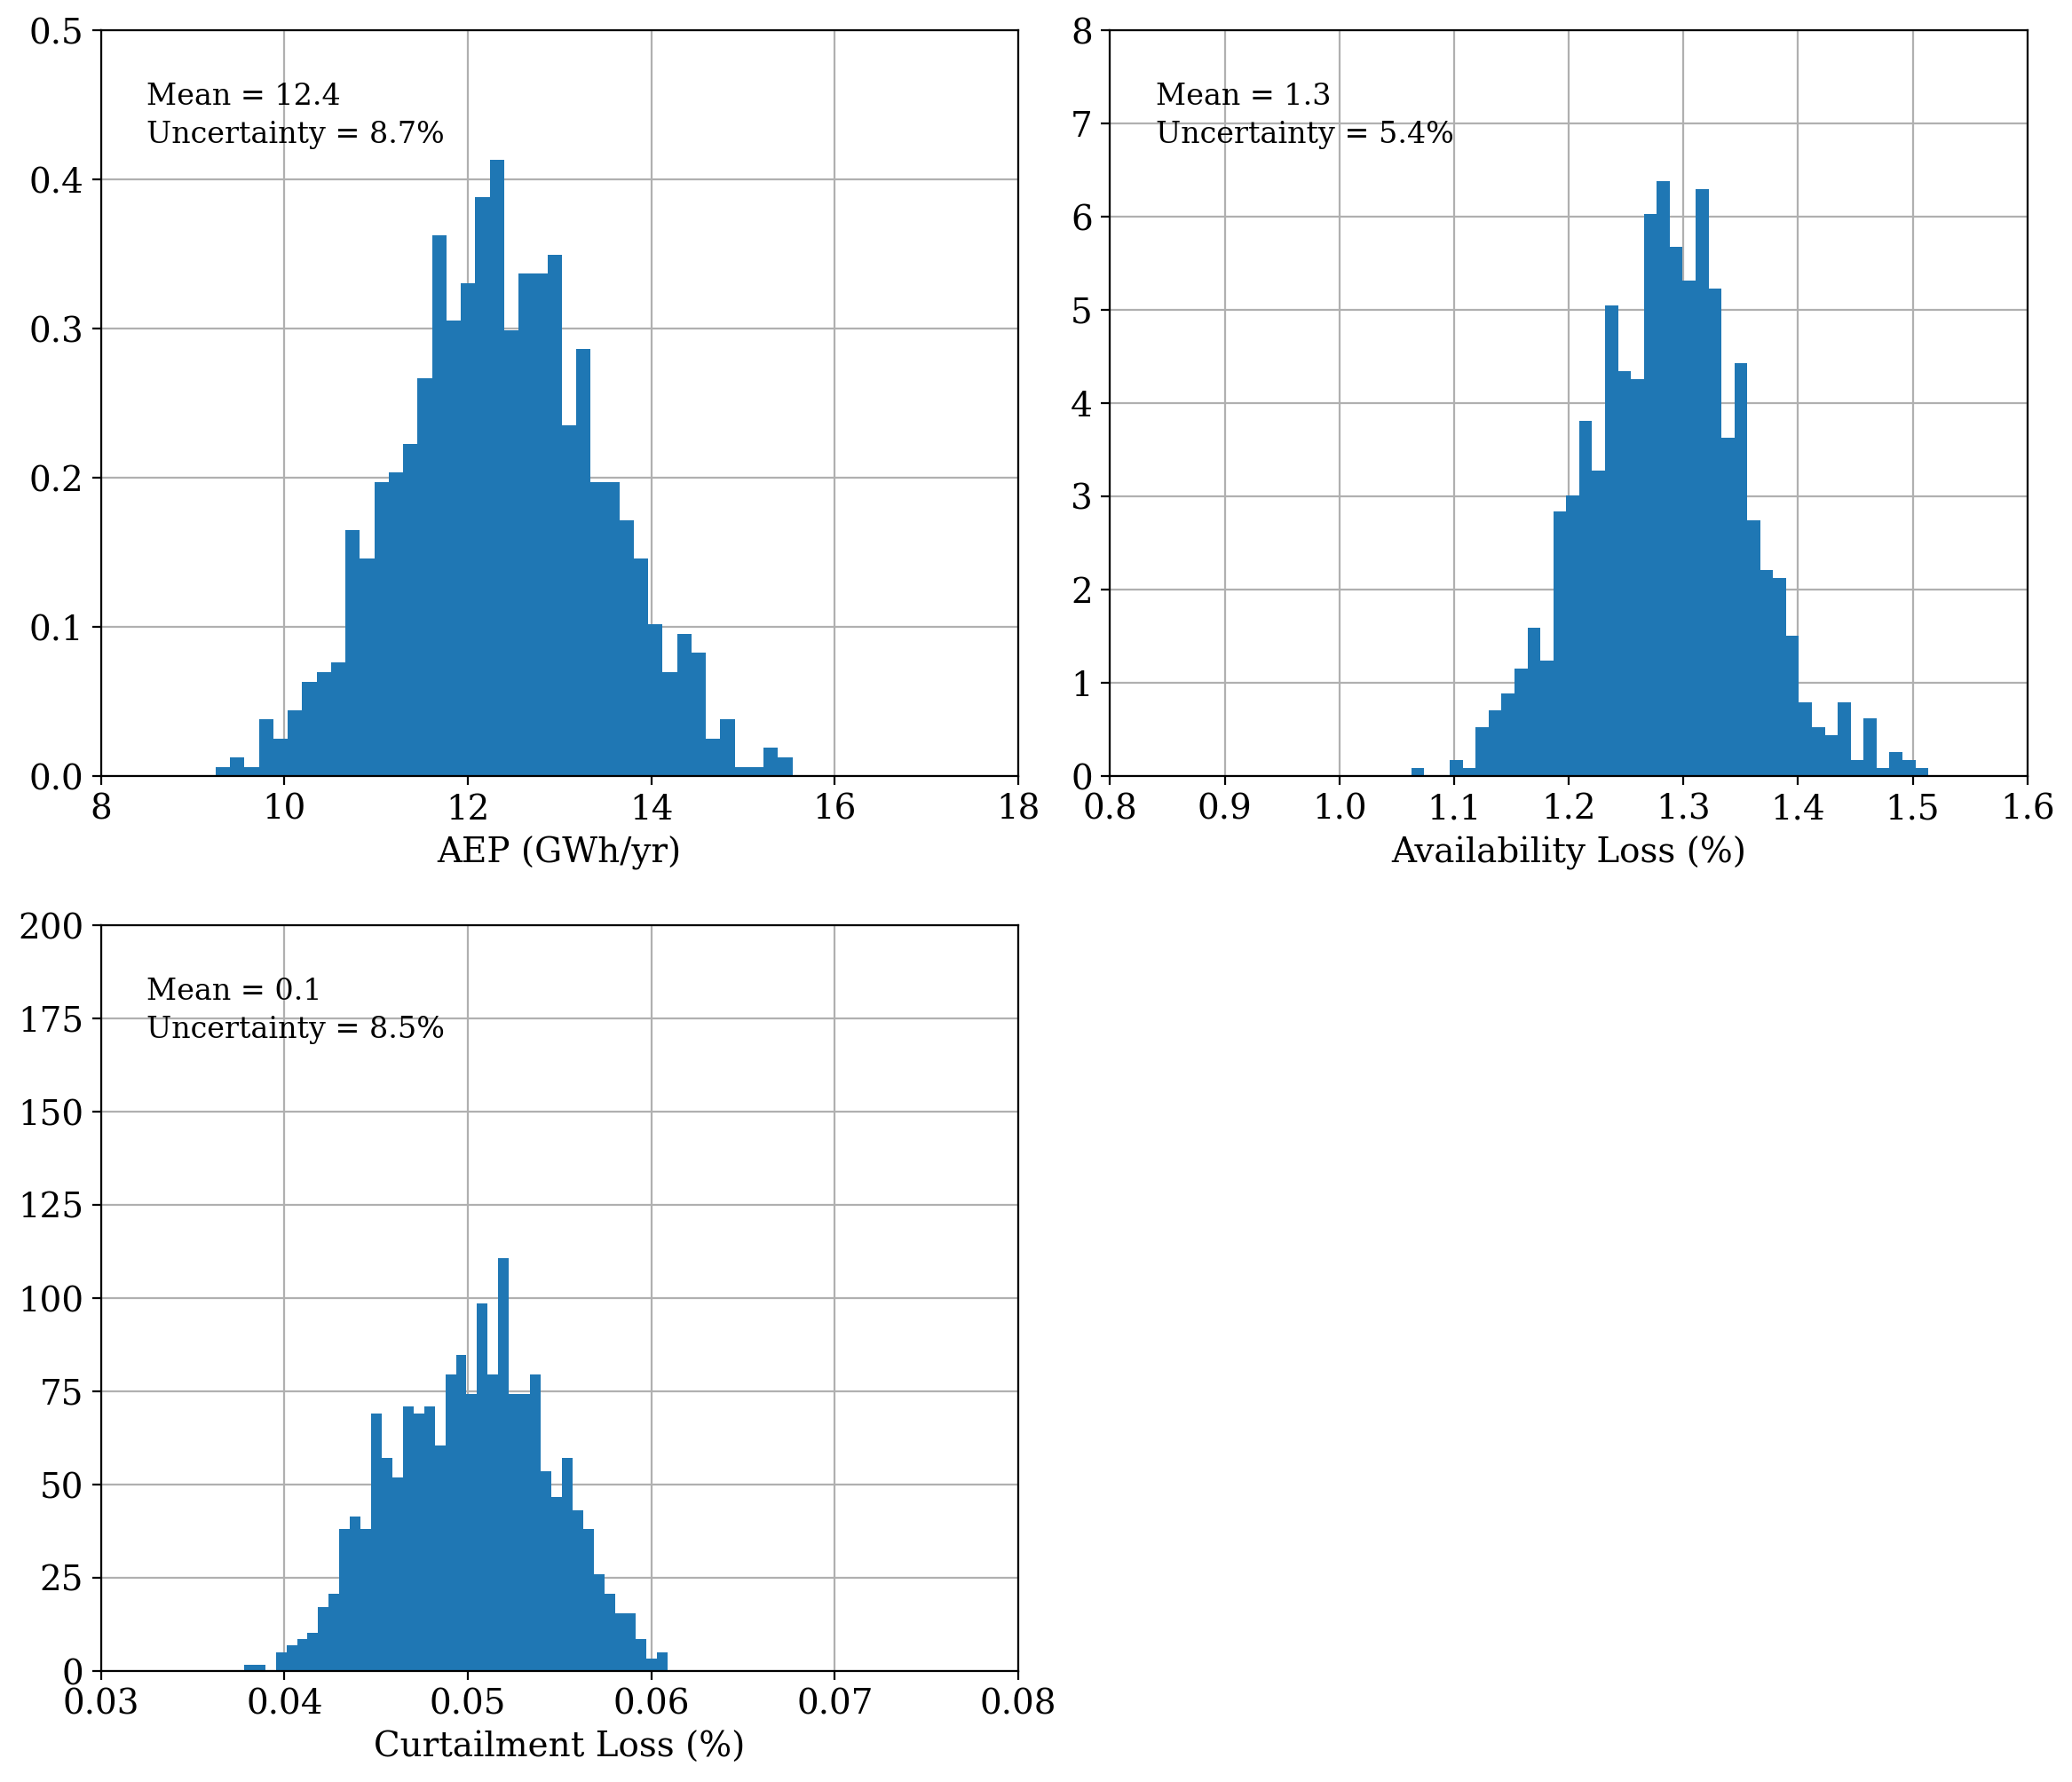

In [14]:
# Plot a distribution of AEP values from the Monte-Carlo OA method - extra randomized tree model
aep_etr.plot_result_aep_distributions(**plotting_kwargs)

For this specific case, we see a decrease in AEP uncertainty when the calculation is performed with a machine learning regression model at daily resolution, which becomes even more significant when performing the calculation at hourly resolution. 
Our analysis on a larger set of wind plants (Bodini et al. 2021, Wind Energy) showed how the uncertainty component connected to the regression decreases by up to 60% (relative change) when moving from monthly to daily resolution, and by up to 80% (relative change) when moving from monthly to hourly resolution. 
Finally, we note how the GBM and ETR regression models are more computationally expensive than the GAM regression model. However, as ensemble-based models, they are expected to be capable of better modeling complex relationships.

## Comparison 2: AEP calculation using various input variables



The other class of augmented capabilities in the AEP class allow the user to include temperature and/or wind direction as additional inputs to the long-term OA, controlled by `reg_temperature` and `reg_wind_direction`, respectively.

Below, we will compute AEP using a multivariate hourly GAM regression, one including wind speed, temperature, and both as inputs, comparing the results with the univariate GAM applied in the previous comparison.

In [15]:
aep_gam_temp = project.MonteCarloAEP(
    reanalysis_products=["merra2", "era5"],
    time_resolution="h",
    reg_temperature=True,
    reg_wind_direction=False,
    reg_model="gam",
)

aep_gam_wd = project.MonteCarloAEP(
    reanalysis_products=["merra2", "era5"],
    time_resolution="h",
    reg_temperature=False,
    reg_wind_direction=True,
    reg_model="gam",
)

aep_gam_temp_wd = project.MonteCarloAEP(
    reanalysis_products=["merra2", "era5"],
    time_resolution="h",
    reg_temperature=True,
    reg_wind_direction=True,
    reg_model="gam",
)

We now run the Monte-Carlo based OA for this new setup:

In [16]:
aep_gam_temp.run(num_sim=1000)
aep_gam_wd.run(num_sim=1000)
aep_gam_temp_wd.run(num_sim=1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [22:07<00:00,  1.33s/it]


And we can now take a look at the AEP distribution:

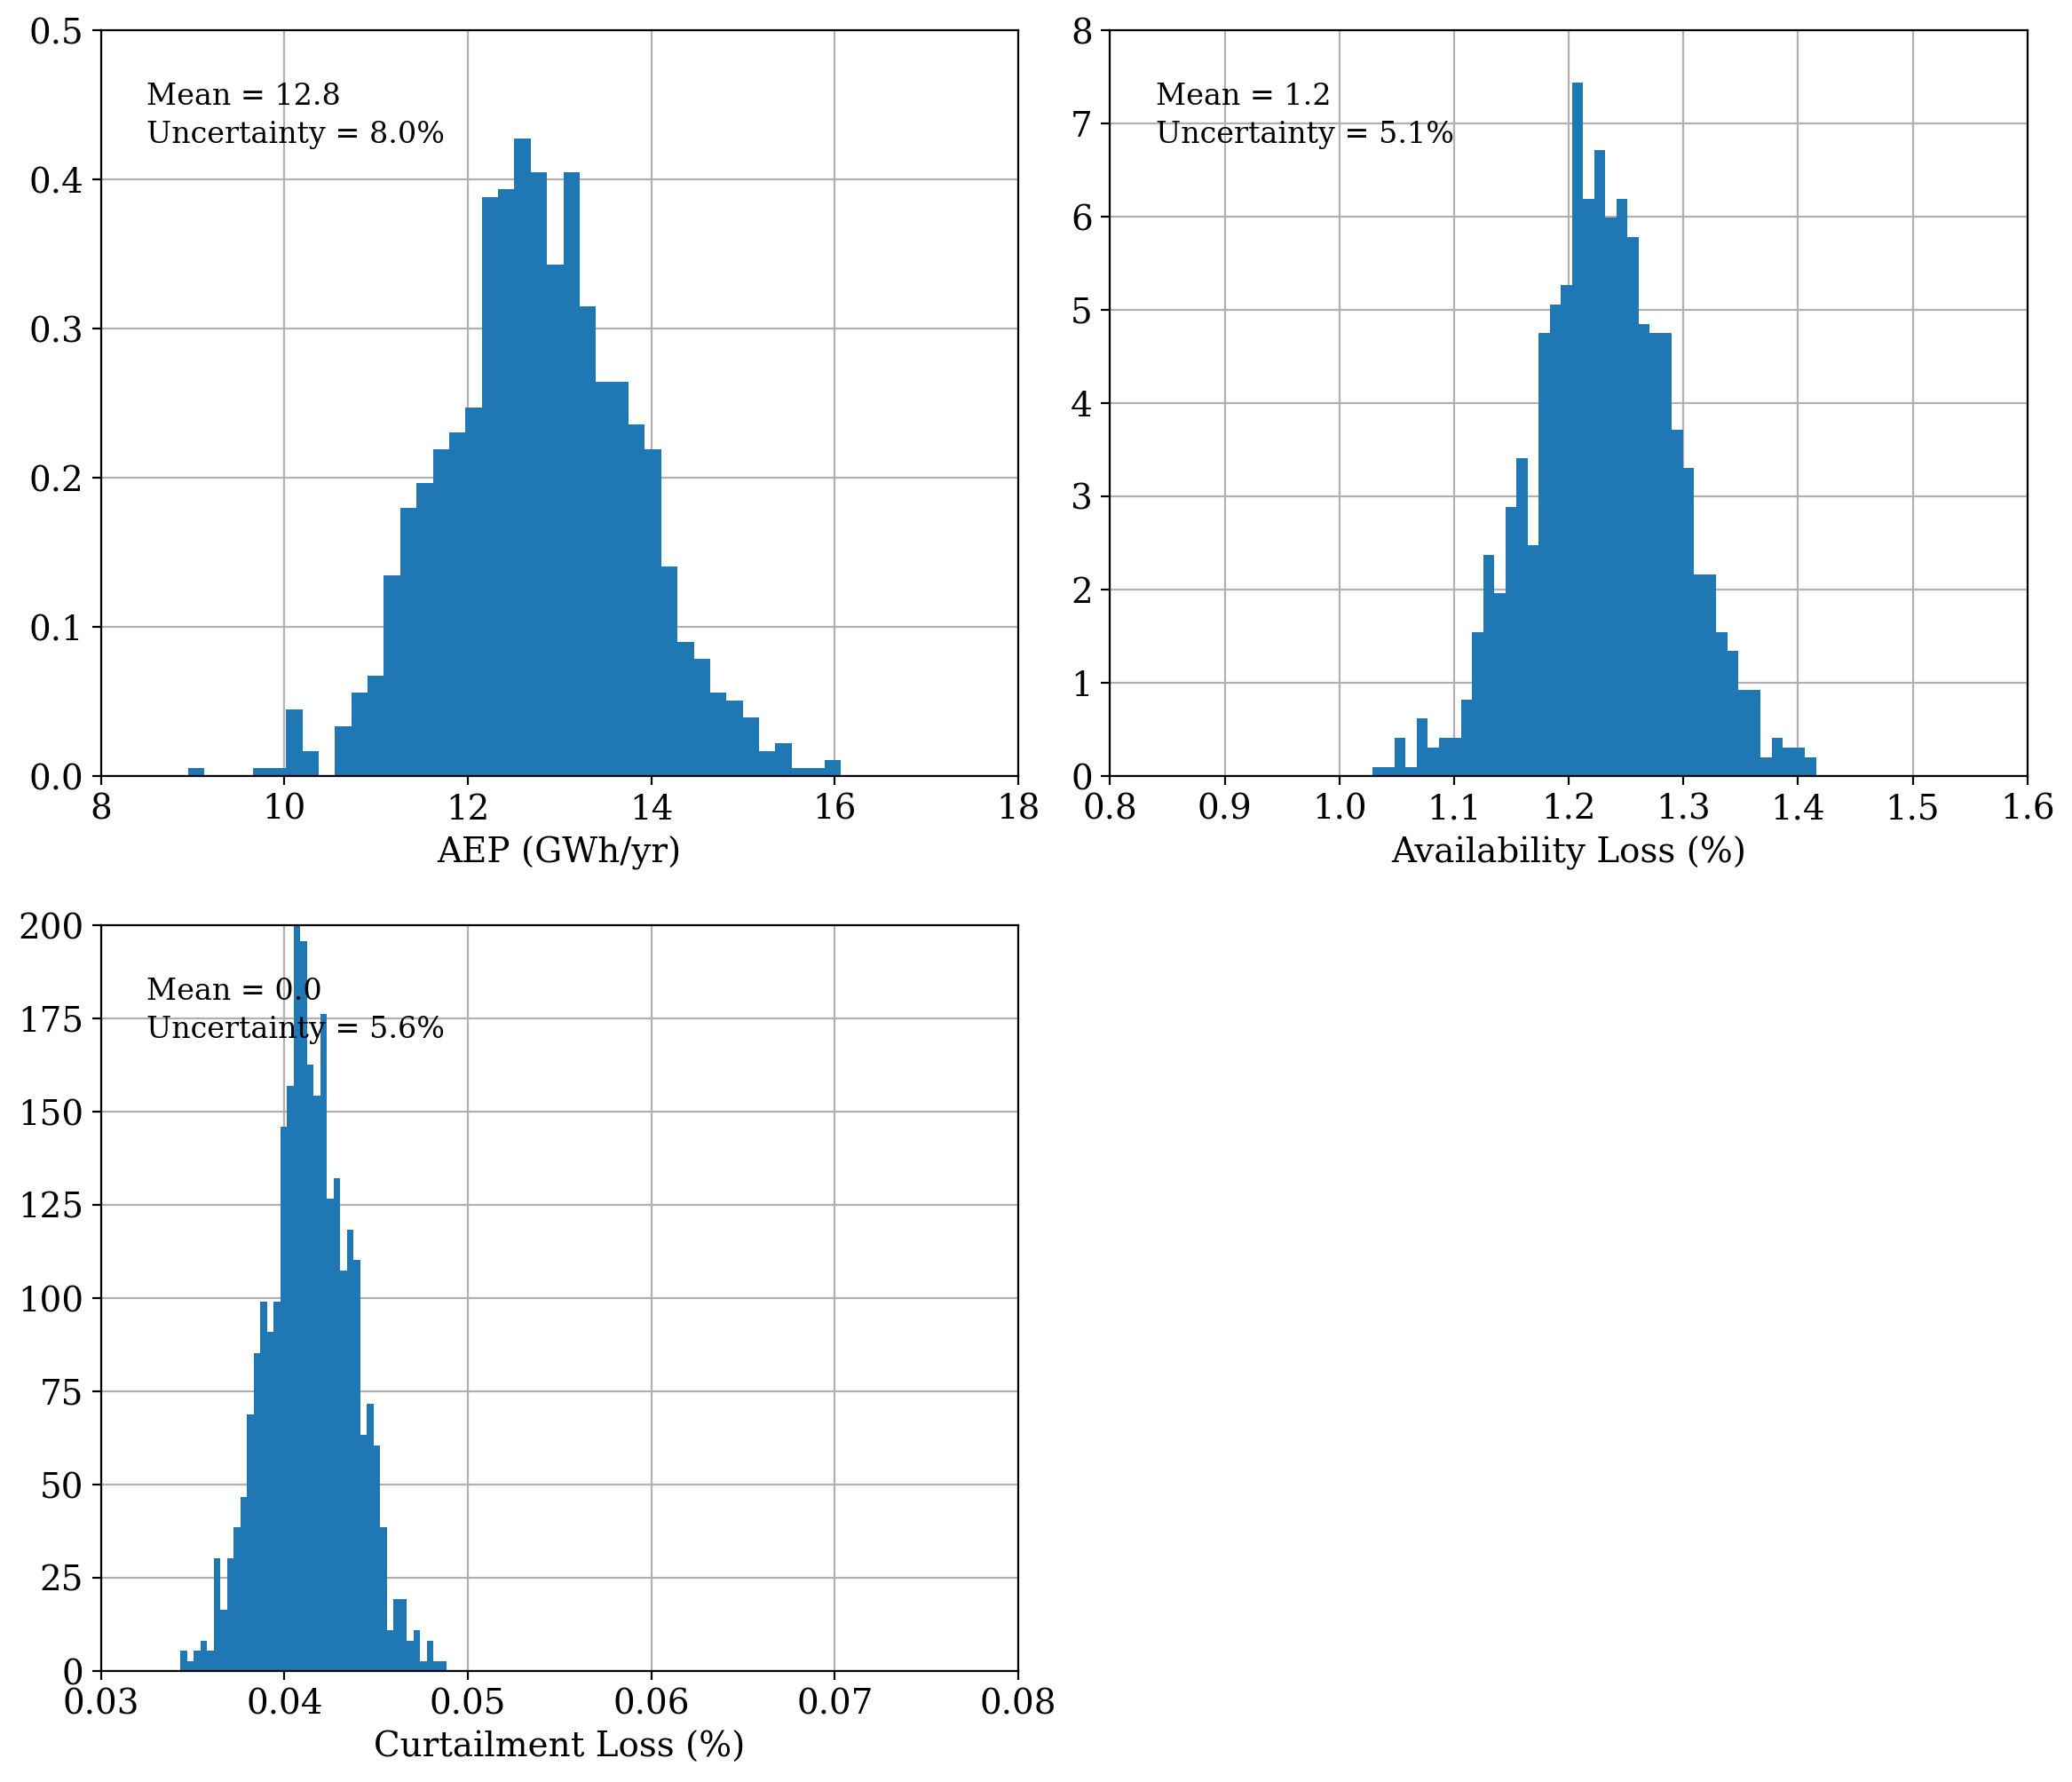

In [17]:
aep_gam_temp.plot_result_aep_distributions(**plotting_kwargs)

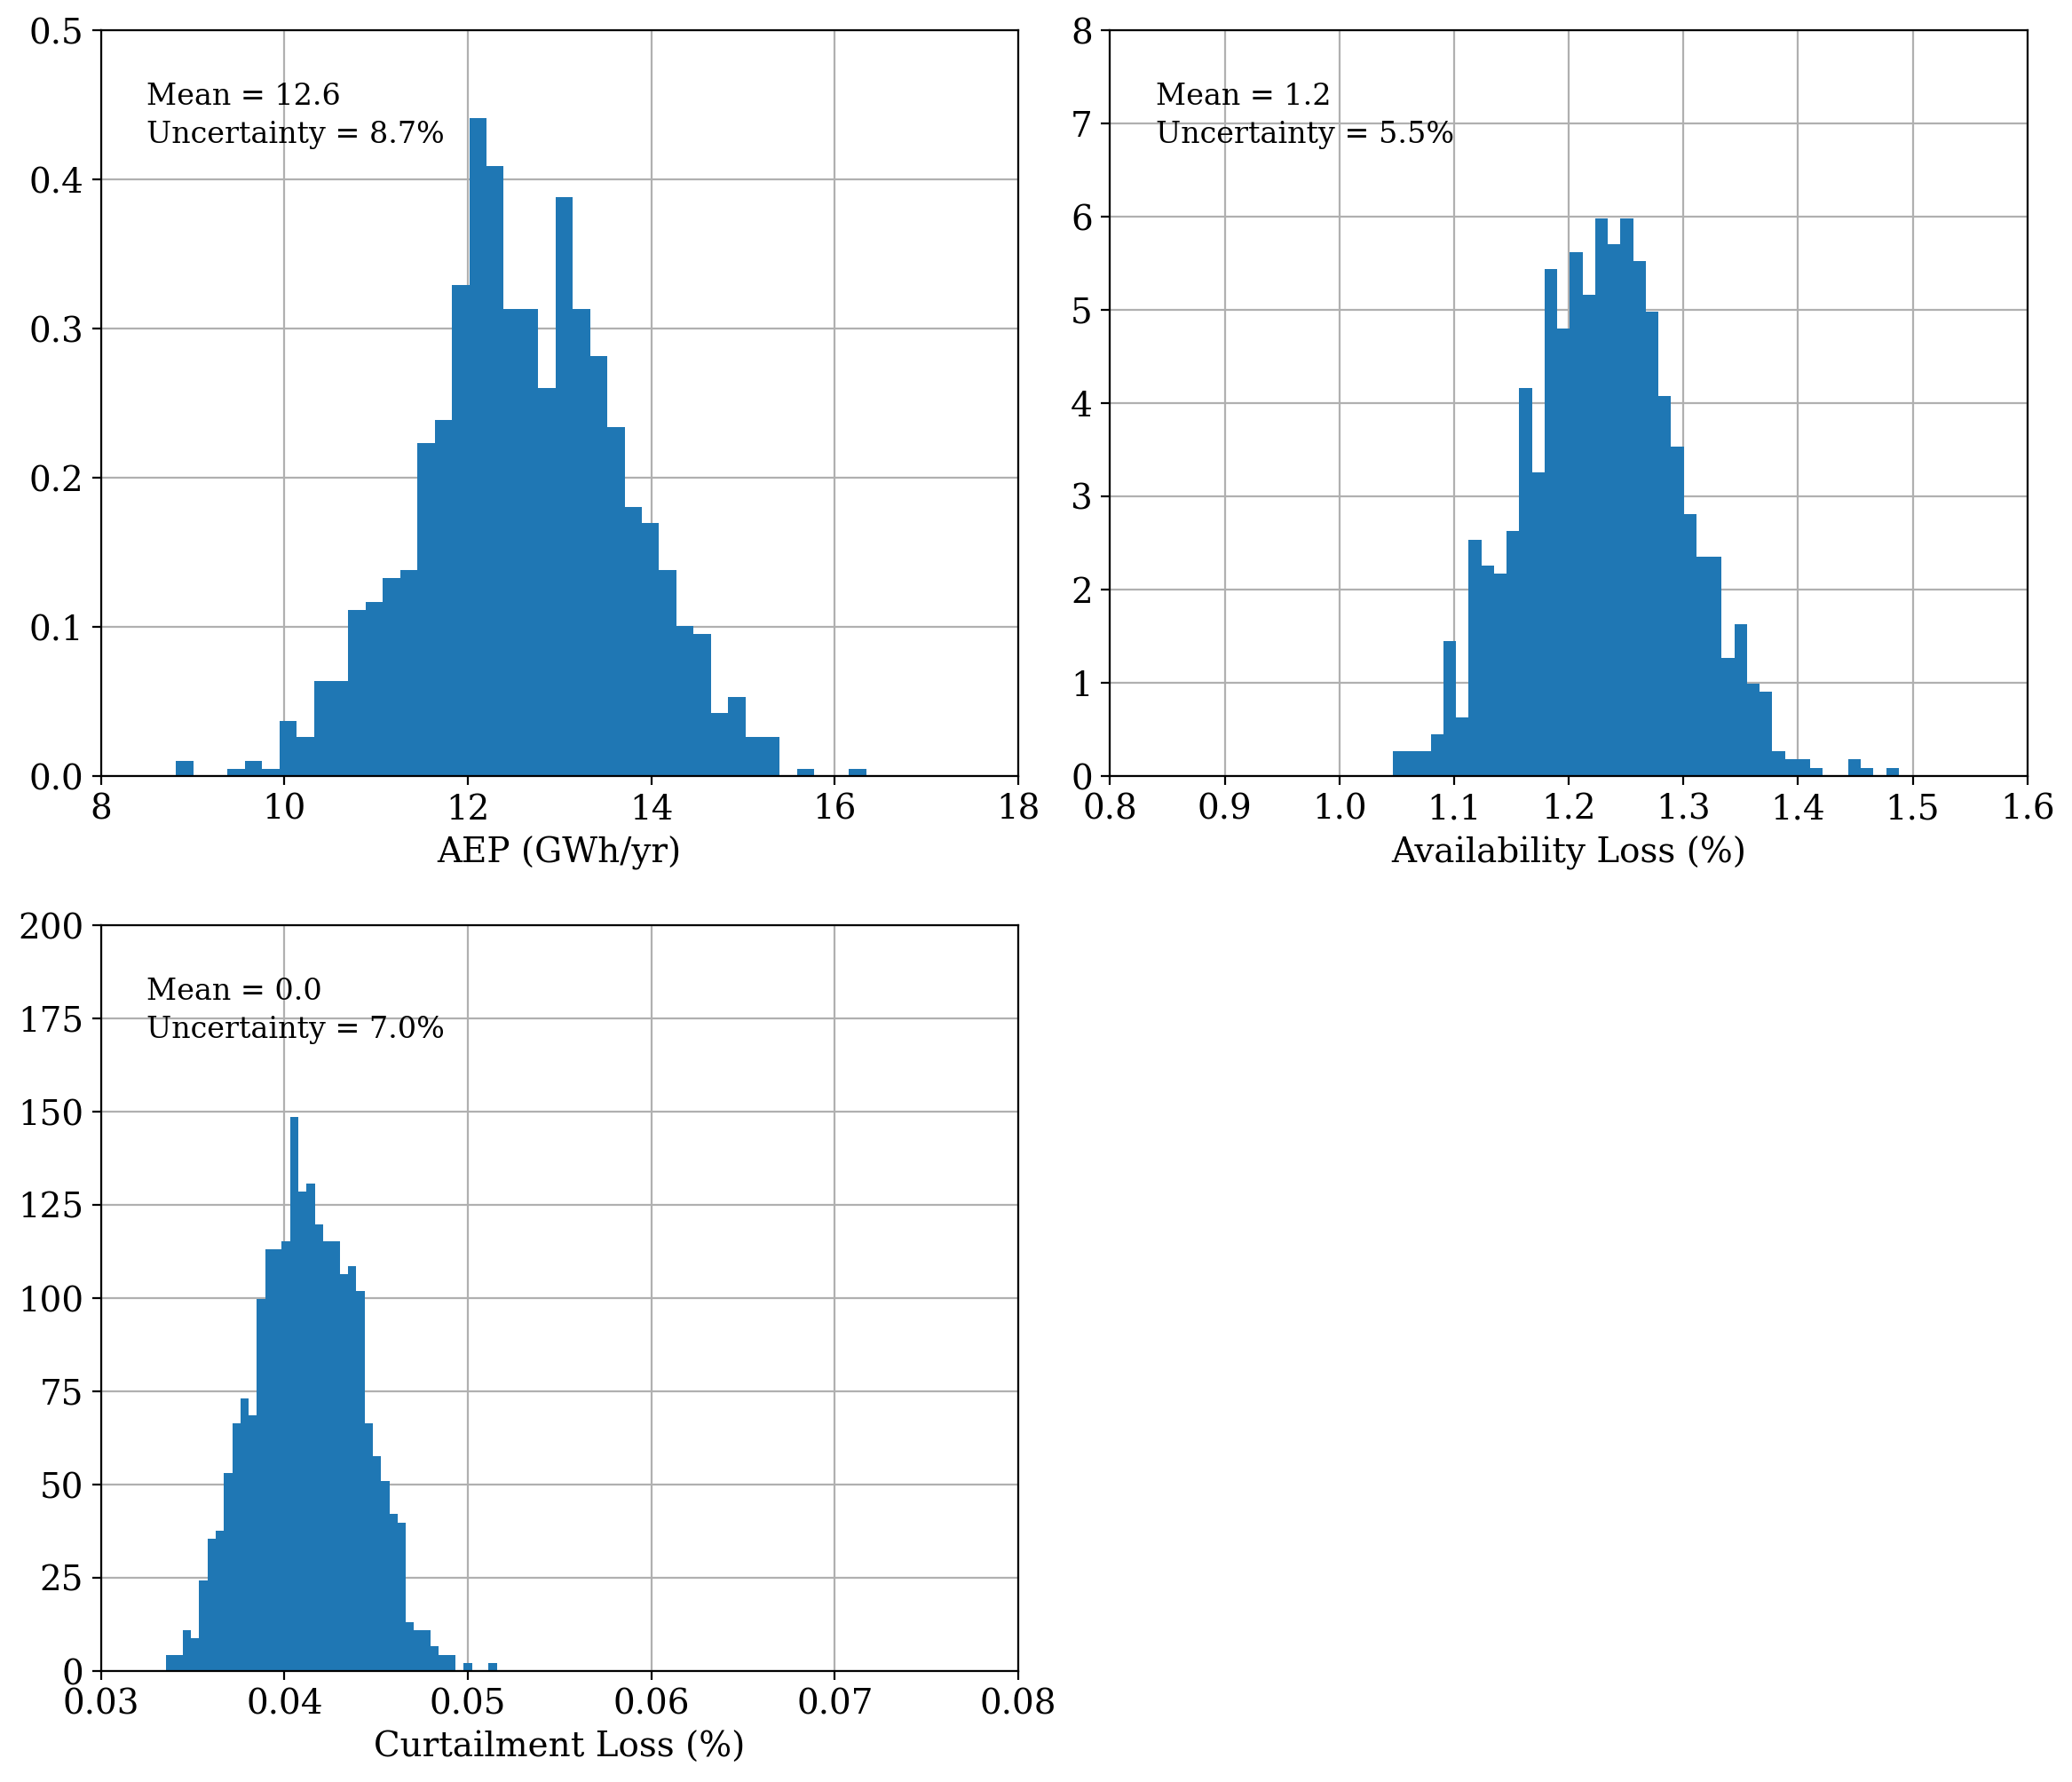

In [18]:
aep_gam_wd.plot_result_aep_distributions(**plotting_kwargs)

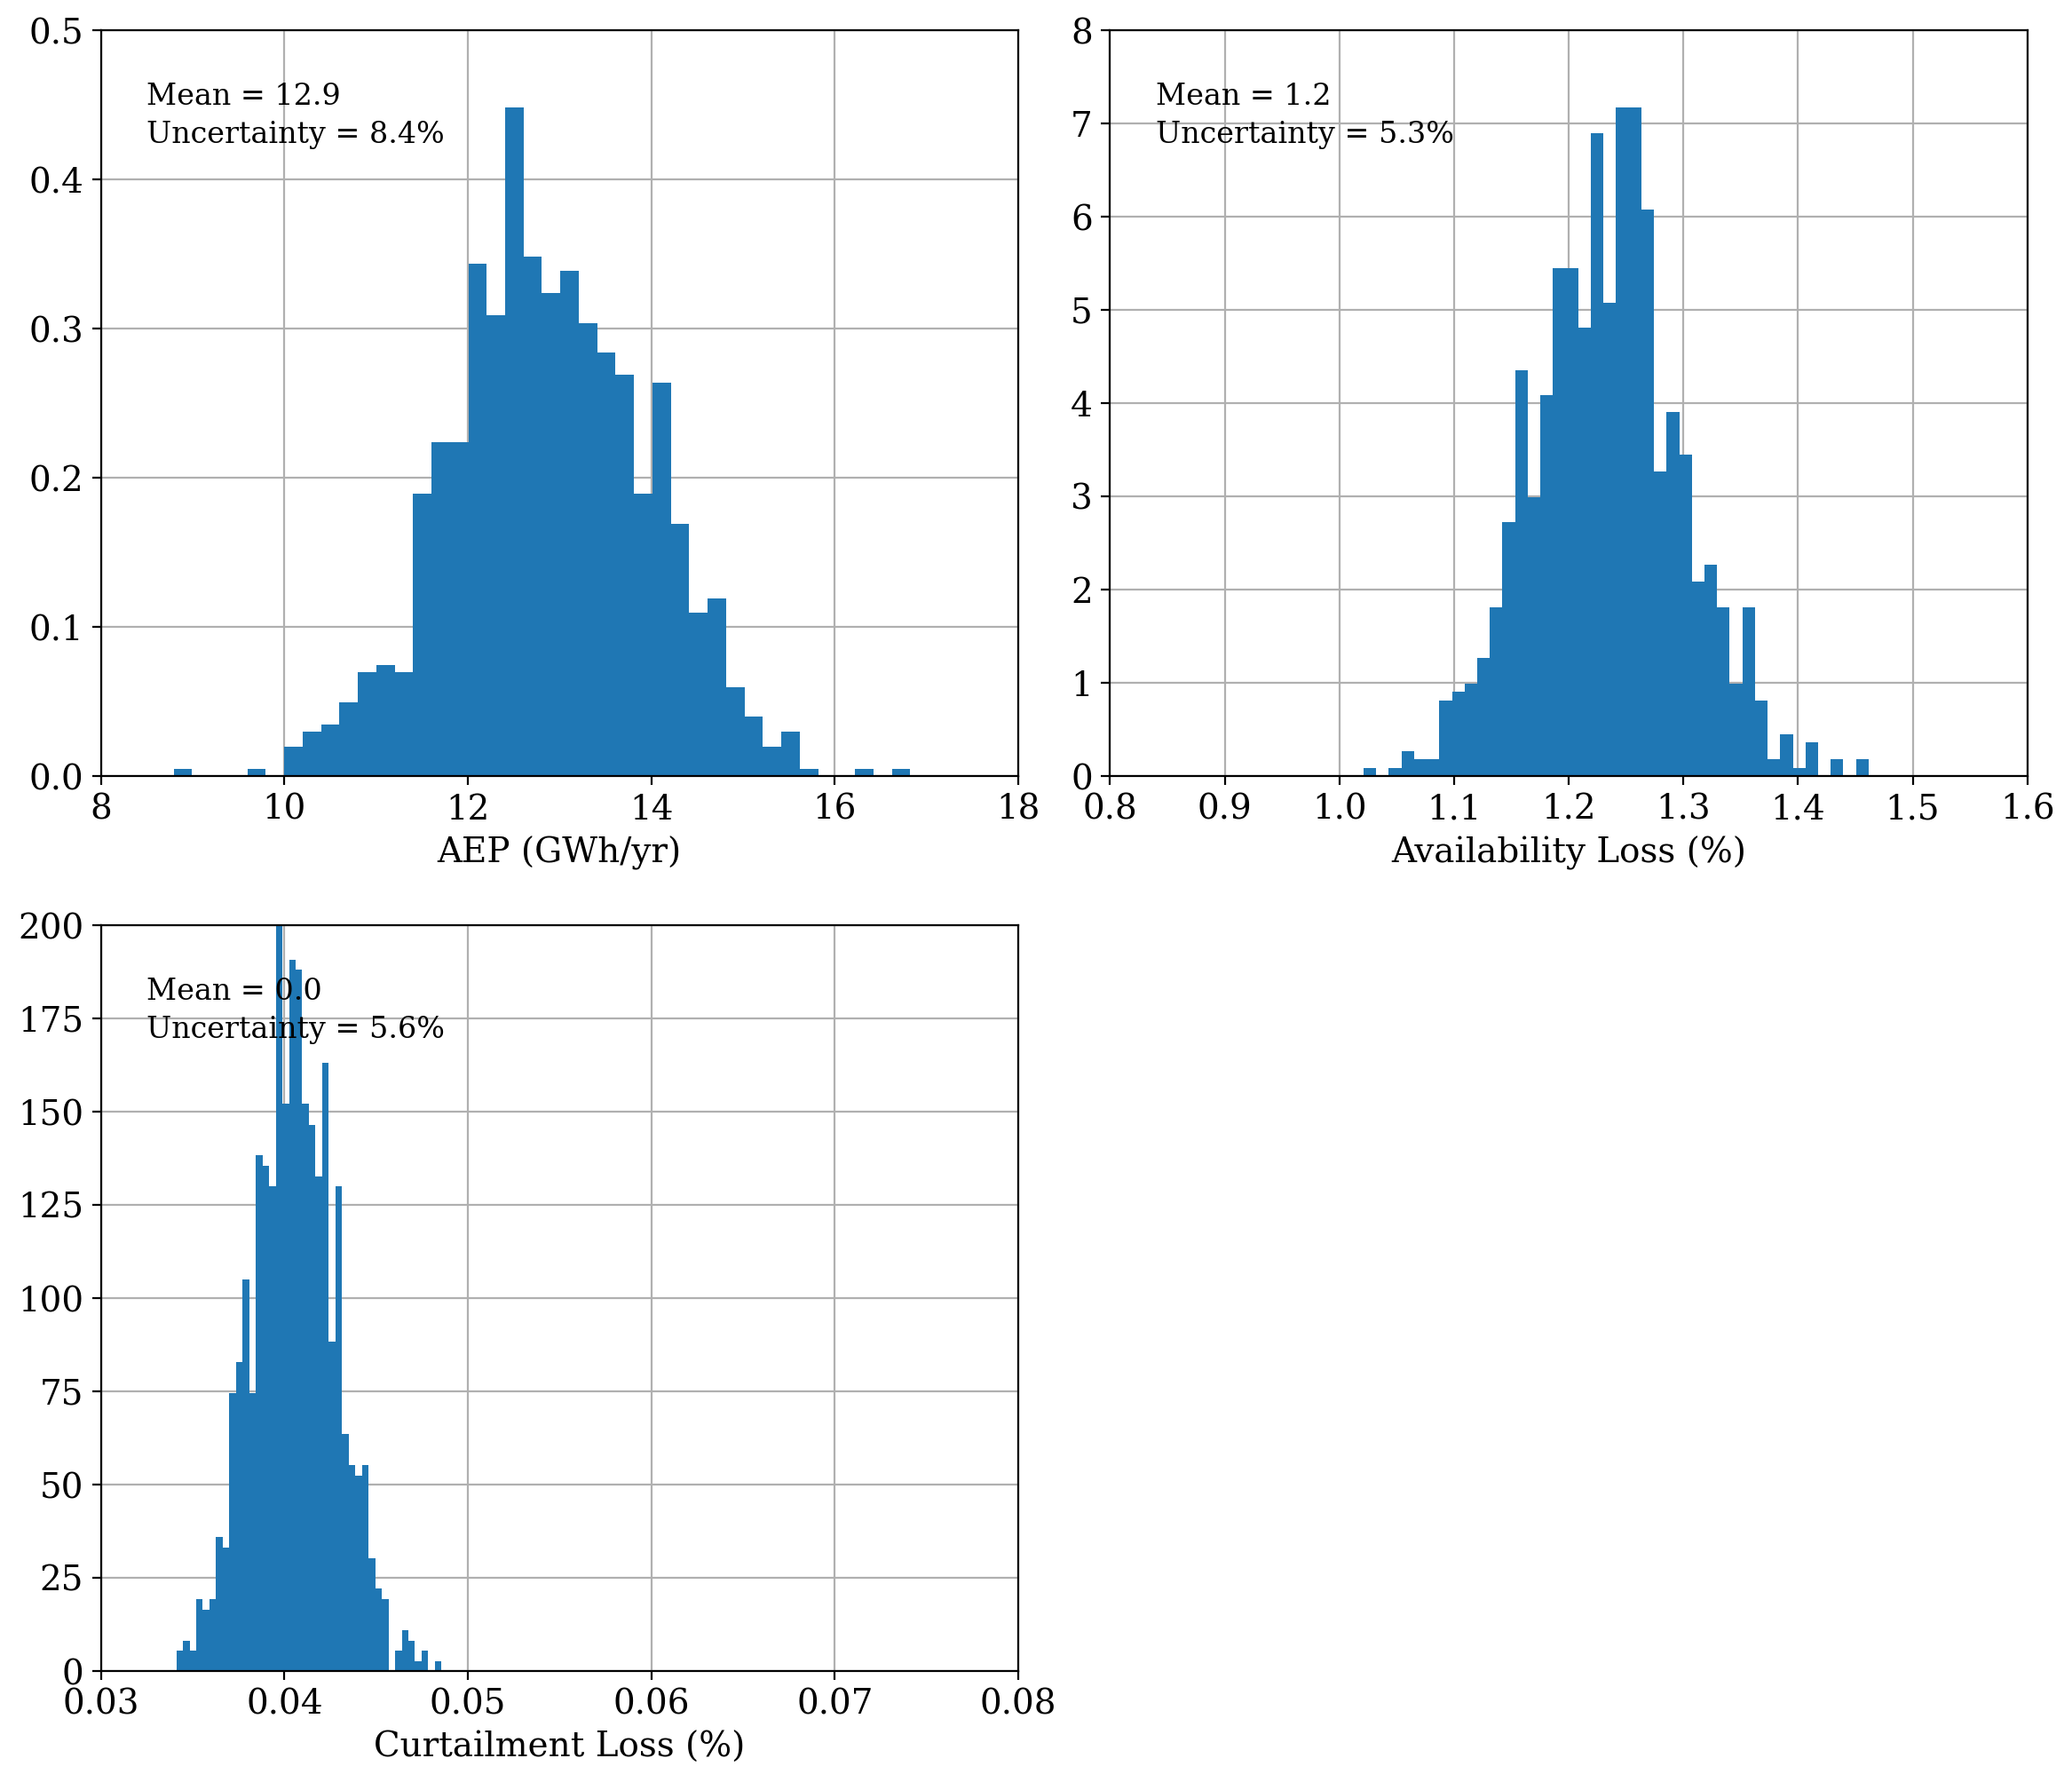

In [19]:
aep_gam_temp_wd.plot_result_aep_distributions(**plotting_kwargs)

In this case, only a slight reduction in AEP uncertainty is achieved when temperature is added as additional input to the hourly GAM regression. Our analysis (Bodini et al. 2021, Wind Energy) showed how adding temperature as additional input has the largest benefits for those wind plants that experience a strong seasonal cycle, which might not be the case for the specific wind plant considered in this example.